In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import animation, rc
from IPython.display import HTML

In [2]:
rho = 0.05
p = 10000
omega = 1
beta = 0.27
tau = 0.5
T = 10

xi = 0

def compute_dt(t, Qt, Q0):
    v1 = np.exp(-tau*omega*t)
    v2 = Qt/Q0
    return v1*v2

def compute_lmbt(t, Qt):
    return Qt * (1-np.exp(-tau*omega*t))

def compute_sgmt(t, Qt, Q0):
    v1 = 1 + (np.power(Q0, -2)-1)*np.exp(-2*tau*omega*t)
    v2 = np.square(Qt)
    
    return np.sqrt(1-v2*v1)

def compute_x(t, x0, Q0): 
    Qt = compute_Q(t, Q0)
    dt = compute_dt(t, Qt, Q0)
    lmbt = compute_lmbt(t, Qt)
    sgmt = compute_sgmt(t, Qt, Q0)
        
    return dt*x0 + sgmt*np.random.randn(*sgmt.shape) + lmbt*xi

def compute_Q(t, Q0):
    q1 = tau*omega*(1+0.5*tau)
    q2 = tau*(omega-0.5*tau)
    
    if q2 == 0:
        val = 1/(np.power(Q0, -2) + q1*t)
    else:
        val = q2 / ((q1 - (q1-q2*np.power(Q0, -2))*np.exp(-2*q2*t)))
        
    return np.sqrt(val)

def gauss_params(ts, Q0):    
    Qt = compute_Q(ts, Q0)
    dt = compute_dt(ts, Qt, Q0)
    lmbt = compute_lmbt(ts, Qt)
    sgmt = compute_sgmt(ts, Qt, Q0)
    
    means = (dt*Q0 + lmbt)*xi
    stds = np.sqrt(1 - np.square(Q0) + np.square(sgmt))
    
    return means, stds

def expon_params(ts, Q0):    
    Qt = compute_Q(ts, Q0)
    dt = compute_dt(ts, Qt, Q0)
    lmbt = compute_lmbt(ts, Qt)
    sgmt = compute_sgmt(ts, Qt, Q0)
    
    means = (dt*Q0 + lmbt)*xi - dt*np.sqrt(1-np.square(Q0))
    betas = dt*np.sqrt(1-np.square(Q0))
    
    return means, betas, sgmt+1e-8

In [3]:
def animator(xs, ts, X_mc, pdfs, fps=30):
    fig, ax = plt.subplots(figsize=(13, 5))
    bins = np.linspace(xs.min(), xs.max(), 25)

    def animate(i):
        plt.cla()
        ax.plot(xs, pdfs[i], lw=4, label='PDE', c='C3')
        ax.hist(X_mc[i], density=True, bins=bins, label='MC', color='C0', alpha=0.75, lw=1.5)
        ax.set_xlim((-5, 5))
        ax.set_ylim((0, 1))
        ax.grid()

        ax.set_xlabel("$x$")
        ax.set_ylabel(fr'''$P(x \mid \xi={round(xi, 2)})$''')
        ax.set_title(fr'''Oja Evolution from $x$ and PDE parameters (T={round(ts[i], 2)})''')
        ax.legend()

        return []
    
    interval = (ts[1] - ts[0])*1000
    return animation.FuncAnimation(fig, animate, frames=len(ts), interval=interval, blit=True)

### Gaussian Initialization

In [6]:
Q0 = 0.15
xs = np.linspace(-5, 5, 100)
ts = np.linspace(0, T, 100)

# Direct parameters
means, stds = gauss_params(ts, Q0)

# MC experiment
ntrial = 1000
mean0 = 1/np.sqrt(2)
std0 = 0.5
x0 = np.random.randn(ntrial)*std0 + mean0
X_mc = []

for i in range(ntrial):
    X_mc.append(compute_x(ts, x0[i], Q0))

X_mc = np.array(X_mc).T
PDFs = np.zeros((len(ts), len(xs)))

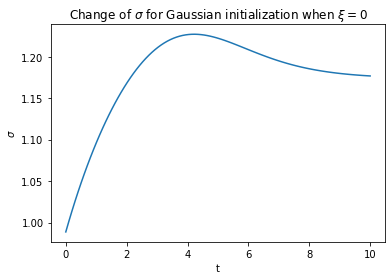

In [7]:
plt.plot(ts, stds)
plt.xlabel("t")
plt.ylabel('$\sigma$')
plt.title(fr'''Change of $\sigma$ for Gaussian initialization when $\xi={round(xi, 2)}$''');

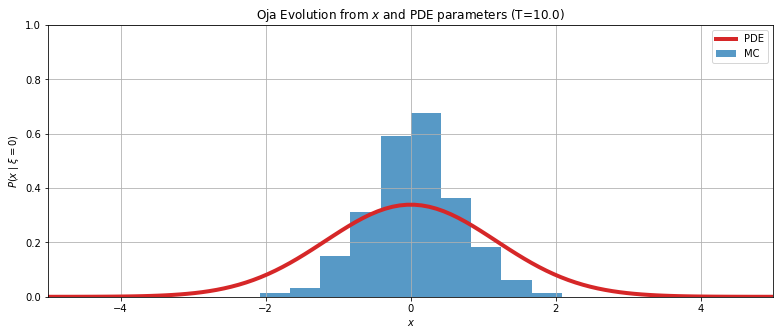

In [8]:
for t in range(len(ts)):
    PDFs[t] = scipy.stats.norm(loc=means[t], scale=stds[t]).pdf(xs)
    
HTML(animator(xs, ts, X_mc, PDFs).to_html5_video())

### Exponential Initialization

In [ ]:
Q0 = 0.15
ts = np.linspace(0,1,100)
xs = np.linspace(-5, 5, 100)

means, betas, stds = expon_params(ts, Q0)

# MC experiment
ntrial = 1000
x0 = scipy.stats.exponnorm(K=1/(betas[0]*stds[0]), loc=means[0], scale=stds[0]).rvs(size=ntrial)

X_mc = []
for i in range(ntrial):
    X_mc.append(compute_x(ts, x0[i], Q0))

X_mc = np.array(X_mc).T
PDFs = np.zeros((len(ts), len(xs)))

In [ ]:
for t in range(len(ts)):
    PDFs[t] = scipy.stats.exponnorm(K=1/(betas[t]*stds[t]), loc=means[t], scale=stds[t]).pdf(xs)
    
HTML(animator(xs, ts, X_mc, PDFs).to_html5_video())